
# Multiple classification task by MedMINIST-pathmnist dataset

* Motivation: exploring whether basic machine learning models can competent in image multiple classification tasks

* Dataset: MedMINIST-pathmnist (RGB image)

* Model: RandomForestClassifier

In [1]:
#ensure you have the following packages installed
from tqdm import tqdm
import numpy as np
import medmnist#pip install medmnist
from medmnist import INFO
from skimage import feature, color
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

/scratch/uceezzz/Environment/p3.8-MedMinist/lib64/python3.8/site-packages/pandas/util/testing.py:27: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  import pandas._libs.testing as _testing


Please install the required packages first. Use `pip install -r requirements.txt`.


In [2]:
#get the dataset we use
data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=None, download=download)
test_dataset = DataClass(split='test', transform=None, download=download)
pil_dataset = DataClass(split='train', download=download)

Using downloaded and verified file: /home/uceezzz/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/uceezzz/.medmnist/pathmnist.npz
Using downloaded and verified file: /home/uceezzz/.medmnist/pathmnist.npz


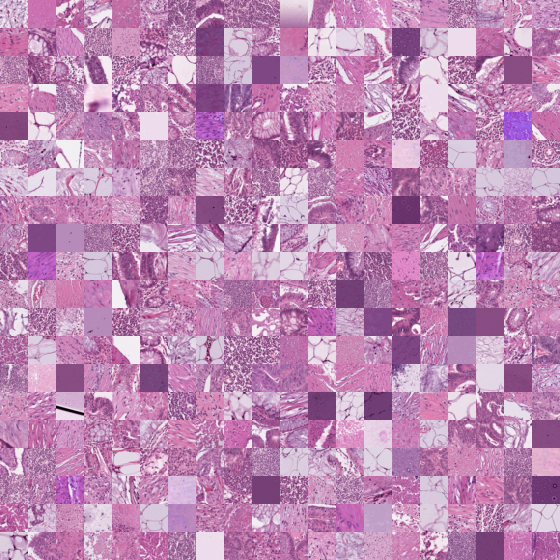

In [3]:

#you can view the samples in the dataset 
train_dataset.montage(length=20)

In [4]:
#extract the raw data from the dataset and convert it to numpy array
'''
For the basic ML model from sklearn, we need to extract the feature from the raw data
For the CNN and other deep NN model, we can use the raw data directly
we convert the RGB image to grayscale image because the grayscale image is easier to extract the feature
and colour information in medical images is often redundant
'''
def extract_data(dataset):
    data, labels = [], []
    for i in range(len(dataset)):
        image = np.array(dataset[i][0])  # Convert PIL Image to numpy array
        label = dataset[i][1]
        grayscale_image = color.rgb2gray(image)
        data.append(grayscale_image)
        labels.append(label)
    return data, labels
x_train, y_train = extract_data(train_dataset)
x_test, y_test = extract_data(test_dataset)

In [5]:
# here we can use some feature extraction methods to extract features from the raw data
# the methods are provided from scikit-image package
'''
use lbp_features
Accuracy: 0.53
'''
def extract_lbp_features(images, P=8, R=1):
    lbp_features = []
    for image in images:
        lbp = feature.local_binary_pattern(image, P=P, R=R, method="uniform")
        # 这里我们简化特征为LBP的直方图
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        lbp_features.append(hist)
    return lbp_features


''' 
use hog_features
Accuracy: 0.46
'''
from skimage.feature import hog
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for image in images:
        fd = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)
        hog_features.append(fd)
    return hog_features



''' 
use gabor_features

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1338
           1       0.97      0.89      0.93       847
           2       0.13      0.04      0.06       339
           3       0.36      0.74      0.48       634
           4       0.49      0.22      0.30      1035
           5       0.24      0.32      0.27       592
           6       0.43      0.07      0.12       741
           7       0.11      0.07      0.09       421
           8       0.48      0.71      0.58      1233

    accuracy                           0.55      7180
   macro avg       0.45      0.45      0.42      7180
weighted avg       0.54      0.55      0.51      7180

'''
from skimage.filters import gabor
def extract_gabor_features(images, frequency=0.6, theta=0):
    gabor_features = []
    for image in images:
        gabor_response = gabor(image, frequency=frequency, theta=theta)
        gabor_features.append(gabor_response[0].ravel())
    return gabor_features








In [6]:
#use the feature extraction method you want
x_train_lbp = extract_gabor_features(x_train)
x_test_lbp = extract_gabor_features(x_test)

In [7]:
#Normalize the data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = x_train_lbp, x_test_lbp, y_train, y_test
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [8]:
#use the ML model you want

#SVM is slow 
# clf = SVC(kernel='linear', probability=True, class_weight='balanced') 

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/scratch/uceezzz/Environment/p3.8-MedMinist/lib64/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
